In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, StratifiedKFold,learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
from typing import Dict, List, Union, Tuple
warnings.filterwarnings('ignore')

## Grid search 

In [ ]:
class KNNGridSearch:
    def __init__(
        self,
        random_state: int = 42,
        test_size: float = 0.2,
        cv_folds: int = 5,
        scoring: str = 'f1',
        n_jobs: int = -1,
        verbose: int = 1
    ):
        self.random_state = random_state
        self.test_size = test_size
        self.cv_folds = cv_folds
        self.scoring = scoring
        self.n_jobs = n_jobs
        self.verbose = verbose
        
    def prepare_data(
        self,
        df: pd.DataFrame,
        target_column: str
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        
        X = df.drop(target_column, axis=1)
        y = df[target_column]
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )
        
        
        return X_train, X_test, y_train, y_test
    
    def create_param_grid(
        self,
        k_range: List[int] = None,
        metrics: List[str] = None,
        weights: List[str] = None,
        p_values: List[int] = None,
        leaf_size: List[int] = None,
        additional_params: Dict = None
    ) -> Dict:

        param_grid = {}
        
        param_grid['n_neighbors'] = k_range if k_range else [3, 5, 7, 9, 11]
        param_grid['metric'] = metrics if metrics else ['euclidean', 'manhattan', 'minkowski']
        param_grid['weights'] = weights if weights else ['uniform', 'distance']
        
        if p_values:
            param_grid['p'] = p_values
        if leaf_size:
            param_grid['leaf_size'] = leaf_size
        if additional_params:
            param_grid.update(additional_params)
            
        return param_grid

    def perform_grid_search(
        self,
        X_train: np.ndarray,
        y_train: np.ndarray,
        param_grid: Dict = None
    ) -> GridSearchCV:

        if param_grid is None:
            param_grid = self.create_param_grid()
            
        knn = KNeighborsClassifier()
        
        grid_search = GridSearchCV(
            estimator=knn,
            param_grid=param_grid,
            cv=self.cv_folds,
            scoring=self.scoring,
            n_jobs=self.n_jobs,
            verbose=self.verbose
        )
        
        grid_search.fit(X_train, y_train)
        return grid_search

    def evaluate_model(
        self,
        grid_search: GridSearchCV,
        X_train: np.ndarray,
        X_test: np.ndarray,
        y_train: np.ndarray,
        y_test: np.ndarray,
    ) -> KNeighborsClassifier:

        print("\nBest Parameters:", grid_search.best_params_)
        print(f"Best Cross-Validation {self.scoring} Score:", 
              round(grid_search.best_score_, 4))
        
        best_model = KNeighborsClassifier(**grid_search.best_params_)
        best_model.fit(X_train, y_train)
        
        y_pred = best_model.predict(X_test)
        
        print("\nTest Set Performance:")
        print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
        print(f"{self.scoring} Score:", 
              round(f1_score(y_test, y_pred), 4))
        print("\nDetailed Classification Report:")
        print(classification_report(y_test, y_pred))
        
        return best_model

    def analyze_hyperparameter_impact(
        self,
        grid_search: GridSearchCV,
        params_to_analyze: List[str] = None
    ) -> Dict[str, pd.DataFrame]:

        results = pd.DataFrame(grid_search.cv_results_)
        analysis_results = {}
        
        if params_to_analyze is None:
            params_to_analyze = ['n_neighbors', 'metric', 'weights']
        
        for param in params_to_analyze:
            param_name = f'param_{param}'
            if param_name in results.columns:
                analysis = results.groupby(param_name)['mean_test_score'].agg(['mean', 'std']).round(4)
                print(f"\nPerformance by {param}:")
                print(analysis)
                analysis_results[param] = analysis
        
        return analysis_results

In [9]:
df = pd.read_csv('../dataset/full_processed_heart_disease_cleveland.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  target    303 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 33.3 KB


In [11]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [ ]:

knn_search = KNNGridSearch(
    random_state=42,
    test_size=0.2,
    cv_folds=5,
    scoring='f1',
    verbose=1
)

X_train, X_test, y_train, y_test = knn_search.prepare_data(
    df=df,
    target_column='target'  
)

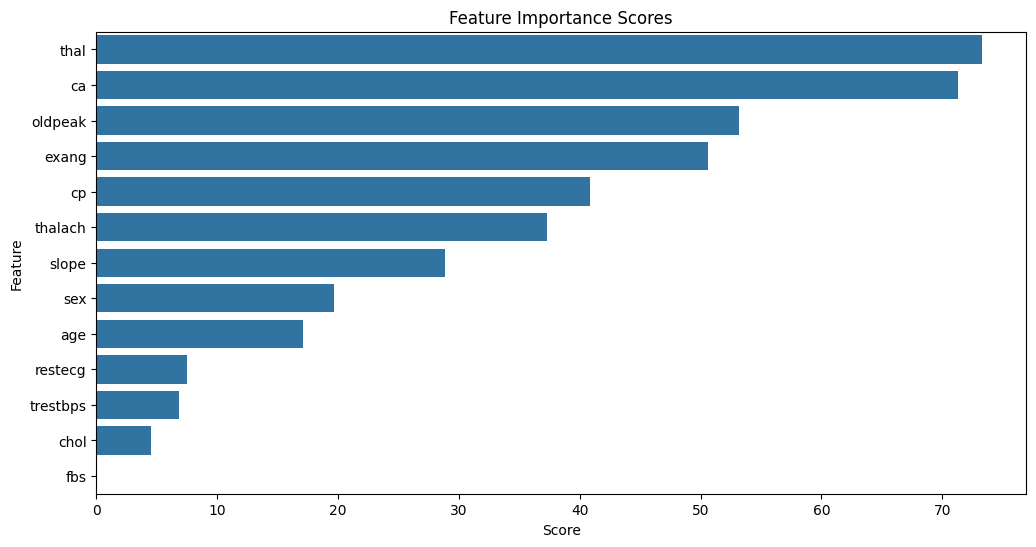


Feature Importance Rankings:
     Feature      Score       P-value
12      thal  73.289174  1.358456e-15
11        ca  71.313341  2.932055e-15
9    oldpeak  53.221508  4.325511e-12
8      exang  50.631747  1.279075e-11
2         cp  40.865578  8.423818e-10
7    thalach  37.312860  4.027347e-09
10     slope  28.887168  1.815264e-07
1        sex  19.658402  1.409924e-05
0        age  17.098167  4.910384e-05
6    restecg   7.536961  6.501999e-03
3   trestbps   6.820594  9.579257e-03
4       chol   4.504305  3.483416e-02
5        fbs   0.023613  8.780035e-01

Significant features: ['thal', 'ca', 'oldpeak', 'exang', 'cp', 'thalach', 'slope', 'sex', 'age', 'restecg', 'trestbps', 'chol']


In [ ]:
def analyze_features(X, y, df_columns):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    

    feature_scores = pd.DataFrame({
        'Feature': df_columns,
        'Score': selector.scores_,
        'P-value': selector.pvalues_
    })
    
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Score', y='Feature', data=feature_scores)
    plt.title('Feature Importance Scores')
    plt.show()
    
    print("\nFeature Importance Rankings:")
    print(feature_scores)
    
    return feature_scores

feature_scores = analyze_features(X_train, y_train, df.drop('target', axis=1).columns)

significant_features = feature_scores[feature_scores['P-value'] < 0.05]['Feature'].tolist()
print("\nSignificant features:", significant_features)

In [ ]:
# Create custom parameter grid (optional)
custom_param_grid = {
    'n_neighbors': [7, 9, 11, 13, 15, 17, 19],  
    'metric': ['manhattan', 'minkowski'],  
    'weights': ['uniform', 'distance'],
    'p': [1, 2],  
    'leaf_size': [20, 30]  
}

In [40]:
grid_search = knn_search.perform_grid_search(
    X_train, 
    y_train,
    param_grid=custom_param_grid
)

best_model = knn_search.evaluate_model(
    grid_search,X_train, X_test, 
    y_train, y_test
)

Fitting 5 folds for each of 112 candidates, totalling 560 fits

Best Parameters: {'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'uniform'}
Best Cross-Validation balanced_accuracy Score: 0.6821

Test Set Performance:
Accuracy: 0.7049
balanced_accuracy Score: 0.7

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        29
           1       0.75      0.66      0.70        32

    accuracy                           0.70        61
   macro avg       0.71      0.71      0.70        61
weighted avg       0.71      0.70      0.70        61



In [22]:
# Analyze the impact of hyperparameters
analysis_results = knn_search.analyze_hyperparameter_impact(
    grid_search,
    params_to_analyze=['n_neighbors', 'metric', 'weights', 'p', 'leaf_size']
)


Performance by n_neighbors:
                     mean     std
param_n_neighbors                
3                  0.5639  0.0221
5                  0.5833  0.0238
7                  0.5859  0.0290
9                  0.5699  0.0235
11                 0.5698  0.0557
13                 0.5601  0.0435
15                 0.5709  0.0353

Performance by metric:
                mean     std
param_metric                
euclidean     0.5440  0.0184
manhattan     0.6075  0.0143
minkowski     0.5644  0.0353

Performance by weights:
                 mean     std
param_weights                
distance       0.5713  0.0329
uniform        0.5726  0.0390

Performance by p:
           mean     std
param_p                
1        0.5864  0.0340
2        0.5652  0.0346
3        0.5644  0.0353

Performance by leaf_size:
                  mean     std
param_leaf_size               
20               0.572  0.0360
30               0.572  0.0362
40               0.572  0.0362


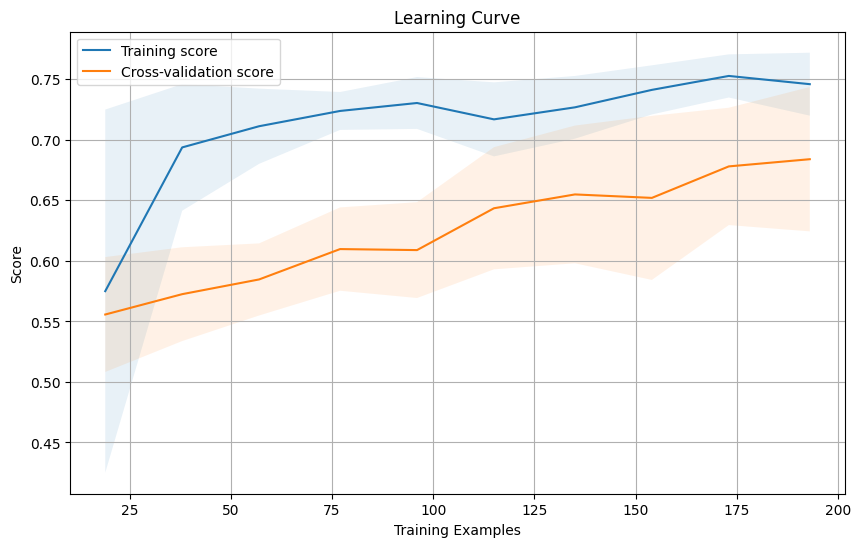

In [ ]:
def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes = np.linspace(0.1, 1.0, 10)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=train_sizes,
        scoring='balanced_accuracy'
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score')
    plt.plot(train_sizes, test_mean, label='Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
    
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curve(best_model, X_train_selected, y_train)


Cross-validation scores:
Mean: 0.6677
Std: 0.0658


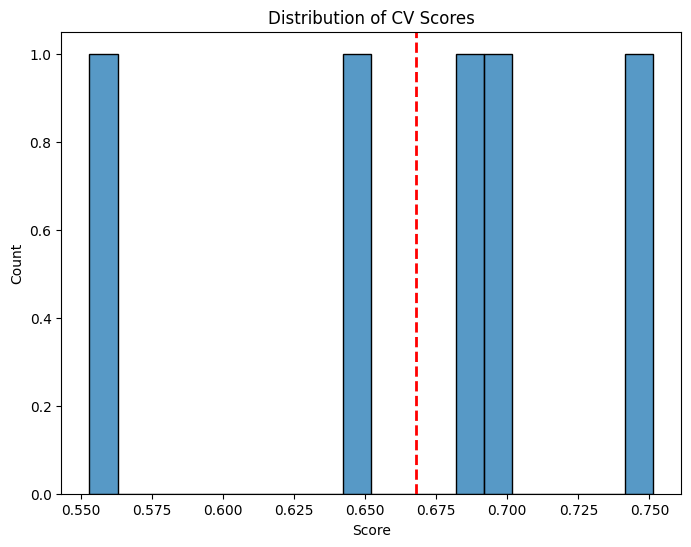

In [ ]:
def plot_cv_distribution(estimator, X, y, cv=5):
    scores = cross_val_score(
        estimator, X, y, 
        cv=StratifiedKFold(n_splits=cv, shuffle=True, random_state=42),
        scoring='balanced_accuracy'
    )
    
    plt.figure(figsize=(8, 6))
    sns.histplot(scores, bins=20)
    plt.axvline(scores.mean(), color='red', linestyle='dashed', linewidth=2)
    plt.title('Distribution of CV Scores')
    plt.xlabel('Score')
    plt.ylabel('Count')
    
    print(f"\nCross-validation scores:")
    print(f"Mean: {scores.mean():.4f}")
    print(f"Std: {scores.std():.4f}")
    plt.show()

plot_cv_distribution(best_model, X_train_selected, y_train)